<a href="https://colab.research.google.com/github/Yuji-ONUKI/GCI2020_Winter/blob/main/June24_1245_home_credit_default_risk_lgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="border-radius:10px;
    border:#410159 solid;
    background-color:#fef1ff;
    font-size:110%;
    letter-spacing:0.5px;
    text-align: center">
<center><h1 style="padding: 25px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Home credit default risk</h1></center>
<center><h3 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">With LightGBM classifier</h3></center>
<center><h4 style="padding-bottom: 25px; color:#410159; font-weight: bold; font-style:italic; font-family: Cursive">(Second challenge)</h4></center>
</div>

In [1864]:
import numpy as np 
import pandas as pd 

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [1865]:
# Google Colaboratoryで作業する場合はこちらも実行してください。
from google.colab import drive
drive.mount('/content/drive')
# %cd 以降にこのnotebookを置いているディレクトリを指定してください。
%cd "/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2


# Import Libraries

In [1866]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# ----------------------------------------------------
import sklearn
import scipy
import statsmodels.api as sm 
from scipy.stats import shapiro

# ----------------------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

# ----------------------------------------------------
from lightgbm import LGBMClassifier

# ----------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Define functions

In [1867]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------------------
def preprocess(df, col):
    print("*********************** {} ***********************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.subplot(2,1,2)
    df[col].plot(kind='density', subplots=True, sharex=False)
    plt.show()

# ----------------------------------------------------------
def preprocess_cat(df, col):
    print("******************** {} ********************\n".format(col))
    df[col].value_counts().plot(kind='bar')
    plt.xticks(rotation='vertical')
    plt.show()
    
# ----------------------------------------------------------
def replace_upper(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 9999999
    upper = q3_col + 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x < (upper)), tmp)
    df[col] = df[col].replace(tmp, upper)

# ----------------------------------------------------------
def replace_lower(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    tmp = 1111111
    lower = q1_col - 1.5 * iqr_col
    df[col] = df[col].where(lambda x: (x > (lower)), tmp)
    df[col] = df[col].replace(tmp, lower)

# ----------------------------------------------------------
def replace_mode(df, col):
    df[col] = df[col].fillna(df[col].mode()[0])
    print("NaN in {} raplaced with {}".format(col, df[col].mode()[0]))

# ----------------------------------------------------------
def replace_mean(df, col):
    df[col] = df[col].fillna(df[col].mean())
    print("NaN in {} raplaced with {}".format(col, df[col].mean()))
    

def replace_median(df, col):
    df[col] = df[col].fillna(df[col].median())
    print("NaN in {} raplaced with {}".format(col, df[col].median()))
    

# ----------------------------------------------------------
kfold = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

def cross_validation(x, y, model):
    result= cross_val_score(model, x, y, cv=kfold, scoring="roc_auc", n_jobs=-1)
    print("Score: %f" % result.mean())
    
# ----------------------------------------------------------
def RndSrch_Tune(model, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='roc_auc', cv = kfold, n_jobs=-1, random_state=100)
    clf.fit(X, y)
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    return (clf.best_score_)

# Data Understanding

In [1868]:
# IPython magic to ensure Python compatibility.
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1869]:
train = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/train.csv")
test = pd.read_csv("/content/drive/MyDrive/GCI/02.（公開）コンペ2-20220621T094535Z-001.zip (Unzipped Files)/02.（公開）コンペ2/input/test.csv")
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,0,Cash loans,F,N,N,0,112500.0,755190.0,36328.5,...,NaN,0.0,0.0,0.0,0.0,-292.0,NaN,NaN,NaN,NaN
1,1,0,Cash loans,F,N,Y,0,225000.0,585000.0,16893.0,...,0.553165,0.0,0.0,0.0,0.0,-617.0,0.0,0.0,0.0,1.0
2,2,0,Cash loans,F,N,Y,0,54000.0,334152.0,18256.5,...,NaN,4.0,0.0,4.0,0.0,-542.0,NaN,NaN,NaN,NaN
3,3,0,Cash loans,F,N,Y,0,67500.0,152820.0,8901.0,...,0.767523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,1,Cash loans,M,N,N,0,157500.0,271066.5,21546.0,...,0.669057,0.0,0.0,0.0,0.0,-1243.0,0.0,0.0,0.0,4.0


In [1870]:
train['OWN_CAR_AGE_64']=0
train['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
train['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_64']=0
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE_64']=1
test['OWN_CAR_AGE'==64,'OWN_CAR_AGE']=np.nan

train['OWN_CAR_AGE_65']=0
train['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
train['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan

test['OWN_CAR_AGE_65']=0
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE_65']=1
test['OWN_CAR_AGE'==65,'OWN_CAR_AGE']=np.nan


# ここから独自のカラムを加えていく。

In [1871]:
# 欠測値であれば'_NAN'を加えたカラムを作る
def flag_isNan(column_target):
    train[column_target+'_NAN']=0
    test[column_target+'_NAN']=0
    #
    train.loc[train[column_target].isna(),column_target+'_NAN']=1
    test.loc[test[column_target].isna(),column_target+'_NAN']=1

In [1872]:
flag_isNan('FLAG_OWN_REALTY')
flag_isNan('AMT_REQ_CREDIT_BUREAU_HOUR')
flag_isNan('AMT_REQ_CREDIT_BUREAU_MON')
flag_isNan('AMT_REQ_CREDIT_BUREAU_QRT')
flag_isNan('AMT_REQ_CREDIT_BUREAU_YEAR')
flag_isNan('OWN_CAR_AGE')
flag_isNan('EXT_SOURCE_1')

In [1873]:
train['RT_CREDIT']=train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
test['RT_CREDIT']=test['AMT_CREDIT']/test['AMT_INCOME_TOTAL']

train['FLAG_RT_CREDIT_OVER1']=0
test['FLAG_RT_CREDIT_OVER1']=0
train.loc[train['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1
test.loc[train['RT_CREDIT']>1,'FLAG_RT_CREDIT_OVER1']=1



In [1874]:
train['RT_GOODS_PRICE']=train['AMT_GOODS_PRICE']/train['AMT_CREDIT']
test['RT_GOODS_PRICE']=test['AMT_GOODS_PRICE']/test['AMT_CREDIT']

In [1875]:
#落ちるのではずした
#train['RT_GOODS_PRICE_INCOME']=train['AMT_GOODS_PRICE']/train['AMT_INCOME_TOTAL']
#test['RT_GOODS_PRICE_INCOME']=test['AMT_GOODS_PRICE']/test['AMT_INCOME_TOTAL']

In [1876]:
train['RT_ANNUITY']=train['AMT_ANNUITY']/train['AMT_CREDIT']
test['RT_ANNUITY']=test['AMT_ANNUITY']/test['AMT_CREDIT']

In [1877]:
#落ちるのではずした
#train['RT_ANNUITY_INCOME']=train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL']
#test['RT_ANNUITY_INCOME']=test['AMT_ANNUITY']/test['AMT_INCOME_TOTAL']

In [1878]:
train['YEARS_ID_PUBLISH']=round(train['DAYS_ID_PUBLISH']/365)
test['YEARS_ID_PUBLISH']=round(test['DAYS_ID_PUBLISH']/365)

In [1879]:
train['YEARS_REGISTRATION']=round(train['DAYS_REGISTRATION']/365)
test['YEARS_REGISTRATION']=round(test['DAYS_REGISTRATION']/365)

In [1880]:
train['YEARS_EMPLOYED']=round(train['DAYS_EMPLOYED']/365)
test['YEARS_EMPLOYED']=round(test['DAYS_EMPLOYED']/365)

train['FLAG_NOT_EMPLOYED']=0
test['FLAG_NOT_EMPLOYED']=0
train.loc[train['YEARS_EMPLOYED']==1001,'FLAG_NOT_EMPLOYED']=1
test.loc[train['YEARS_EMPLOYED']==1001,'FLAG_NOT_EMPLOYED']=1
train.loc[train['YEARS_EMPLOYED']==1001,'YEARS_EMPLOYED']=np.NaN    #デフォルト発生率が勤続20年と同程度のため
test.loc[train['YEARS_EMPLOYED']==1001,'YEARS_EMPLOYED']=np.NaN     #デフォルト発生率が勤続20年と同程度のため

In [1881]:
train['YEARS_BIRTH']=round(train['DAYS_BIRTH']/365)
test['YEARS_BIRTH']=round(test['DAYS_BIRTH']/365)

train['FLAG_UNDER30']=0
test['FLAG_UNDER30']=0
train.loc[train['YEARS_BIRTH']<30,'FLAG_UNDER30']=1
test.loc[train['YEARS_BIRTH']<30,'FLAG_UNDER30']=1


In [1882]:
#train['FLAG_FAM_MEM_EQ_2']=0
#test['FLAG_FAM_MEM_EQ_2']=0
#
#train.loc[train['CNT_FAM_MEMBERS']==2,'FLAG_FAM_MEM_EQ_2']=1
#test.loc[train['CNT_FAM_MEMBERS']==2,'FLAG_FAM_MEM_EQ_2']=1


In [1883]:
#落ちるのではずした
#from numpy.ma.core import log
#train['AMT_ANNUITY_LOG']=0
#test['AMT_ANNUITY_LOG']=0

#train.loc[train['AMT_ANNUITY']>0,'AMT_ANNUITY_LOG']=np.log(train.loc[train['AMT_ANNUITY']>0,'AMT_ANNUITY'])
#test.loc[test['AMT_ANNUITY']>0,'AMT_ANNUITY_LOG']=np.log(test.loc[test['AMT_ANNUITY']>0,'AMT_ANNUITY'])

In [1884]:
train['YEARS_LAST_PHONE_CHANGE']=round(train['DAYS_LAST_PHONE_CHANGE']/365)
test['YEARS_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/365)

In [1885]:
train['MONTH_LAST_PHONE_CHANGE']=round(train['DAYS_LAST_PHONE_CHANGE']/30)
test['MONTH_LAST_PHONE_CHANGE']=round(test['DAYS_LAST_PHONE_CHANGE']/30)

In [1886]:
train['FLAG_D30']=1
test['FLAG_D30']=1
#
train.loc[train['DEF_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D30']=0
test.loc[train['DEF_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D30']=0


In [1887]:
train['FLAG_D60']=1
test['FLAG_D60']=1
#
train.loc[train['DEF_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D60']=0
test.loc[train['DEF_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_D60']=0


In [1888]:
train['FLAG_O30']=1
test['FLAG_O30']=1
#
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O30']=0
test.loc[train['OBS_30_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O30']=0
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==0,'FLAG_O30']=0
test.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==0,'FLAG_O30']=0
train.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==1,'FLAG_O30']=0
test.loc[train['OBS_30_CNT_SOCIAL_CIRCLE']==1,'FLAG_O30']=0
#
train.drop(['OBS_30_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)
test.drop(['OBS_30_CNT_SOCIAL_CIRCLE'], axis=1, inplace=True)

In [1889]:
train['FLAG_O60']=1
test['FLAG_O60']=1
#
train.loc[train['OBS_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O60']=0
test.loc[train['OBS_60_CNT_SOCIAL_CIRCLE'].isna(),'FLAG_O60']=0

カテゴリの値別のデフォルト率を数値とするカラムを作る。名称は'NUM_'を頭に付けたもの

In [1890]:
t1=train.loc[train['TARGET']==1]
t0=train.loc[train['TARGET']==0]
ta=train

In [1891]:
def addColumnOfNumber(column_target):
    column_new = 'NUM_'+column_target
    cats = ta[column_target].unique()

    dict={}
    for cat in cats:
      dict[cat]=(t1.loc[ta[column_target]==cat,'SK_ID_CURR'].count()/ta.loc[ta[column_target]==cat,'SK_ID_CURR'].count()).astype(str)

    train[column_new]=train[column_target]
    test[column_new]=test[column_target]

    train[column_new]=train[column_new].map(dict)
    test[column_new]=test[column_new].map(dict)

    train[column_new]=train[column_new].astype(float)
    test[column_new]=test[column_new].astype(float)

In [1892]:
addColumnOfNumber('ORGANIZATION_TYPE')
addColumnOfNumber('NAME_FAMILY_STATUS')
addColumnOfNumber('NAME_INCOME_TYPE')
addColumnOfNumber('NAME_EDUCATION_TYPE')
addColumnOfNumber('NAME_HOUSING_TYPE')
addColumnOfNumber('NAME_TYPE_SUITE')
addColumnOfNumber('YEARS_BIRTH')
addColumnOfNumber('YEARS_LAST_PHONE_CHANGE')
#addColumnOfNumber('YEARS_ID_PUBLISH')
#addColumnOfNumber('CNT_FAM_MEMBERS')
#addColumnOfNumber('OCCUPATION_TYPE')

住宅・年収・ローン年収倍率別の破綻率を作る。残念ながら落ちるので取りやめ。

In [1893]:
#train['TMP_FLAG_OWN_REALTY']=train['FLAG_OWN_REALTY']
#train.loc[train['TMP_FLAG_OWN_REALTY'].isna(),'TMP_FLAG_OWN_REALTY']='O'
#train['ROUND_AMT_INCOME_TOTAL']=round(train['AMT_INCOME_TOTAL']/100000)
#train.loc[train['ROUND_AMT_INCOME_TOTAL']>6,'ROUND_AMT_INCOME_TOTAL']=6
#train['ROUND_AMT_INCOME_TOTAL']=train['ROUND_AMT_INCOME_TOTAL'].astype(str)
#train['ROUND_RT_CREDIT']=round(train['RT_CREDIT'])
#train.loc[train['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#train['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#train['ROUND_RT_CREDIT']=train['ROUND_RT_CREDIT'].astype(str)
#train['REALTY_INCOME_CREDIT']=train['TMP_FLAG_OWN_REALTY']+train['ROUND_AMT_INCOME_TOTAL']+train['ROUND_RT_CREDIT']
#train.drop(['TMP_FLAG_OWN_REALTY'], axis=1, inplace=True)
#train.drop(['ROUND_AMT_INCOME_TOTAL'], axis=1, inplace=True)
#train.drop(['ROUND_RT_CREDIT'], axis=1, inplace=True)
#
#test['TMP_FLAG_OWN_REALTY']=test['FLAG_OWN_REALTY']
#test.loc[test['TMP_FLAG_OWN_REALTY'].isna(),'TMP_FLAG_OWN_REALTY']='O'
#test['ROUND_AMT_INCOME_TOTAL']=round(test['AMT_INCOME_TOTAL']/100000)
#test['ROUND_AMT_INCOME_TOTAL'].fillna(0,inplace=True)
#test.loc[test['ROUND_AMT_INCOME_TOTAL']>6,'ROUND_AMT_INCOME_TOTAL']=6
#test['ROUND_AMT_INCOME_TOTAL']=test['ROUND_AMT_INCOME_TOTAL'].astype(str)
#test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
#test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
#test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
#test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)
#test['REALTY_INCOME_CREDIT']=test['TMP_FLAG_OWN_REALTY']+test['ROUND_AMT_INCOME_TOTAL']+test['ROUND_RT_CREDIT']
#test.drop(['TMP_FLAG_OWN_REALTY'], axis=1, inplace=True)
#test.drop(['ROUND_AMT_INCOME_TOTAL'], axis=1, inplace=True)
#test.drop(['ROUND_RT_CREDIT'], axis=1, inplace=True)
# REALTY_INCOME_CREDIT だけが残る。
#
#addColumnOfNumber('REALTY_INCOME_CREDIT')
#train.drop(['REALTY_INCOME_CREDIT'], axis=1, inplace=True)  #NUM_REALTY_INCOME_CREDIT だけが残る。
#test.drop(['REALTY_INCOME_CREDIT'], axis=1, inplace=True)   #NUM_REALTY_INCOME_CREDIT だけが残る。
#train.drop(['FLAG_OWN_REALTY_NAN'], axis=1, inplace=True)  #NUM_REALTY_INCOME_CREDIT だけが残る。
#test.drop(['FLAG_OWN_REALTY_NAN'], axis=1, inplace=True)   #NUM_REALTY_INCOME_CREDIT だけが残る。


借入収入比率のカテゴリー化　ワンホットエンコーディングでリベンジ

In [1894]:
train['ROUND_RT_CREDIT']=round(train['RT_CREDIT'])
train['ROUND_RT_CREDIT'].fillna(0,inplace=True)
train.loc[train['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
train['ROUND_RT_CREDIT']=train['ROUND_RT_CREDIT'].astype(str)

train=pd.get_dummies(train,columns=['ROUND_RT_CREDIT'])

test['ROUND_RT_CREDIT']=round(test['RT_CREDIT'])
test['ROUND_RT_CREDIT'].fillna(0,inplace=True)
test.loc[test['ROUND_RT_CREDIT']>6,'ROUND_RT_CREDIT']=6
test['ROUND_RT_CREDIT']=test['ROUND_RT_CREDIT'].astype(str)

test=pd.get_dummies(test,columns=['ROUND_RT_CREDIT'])


In [1895]:
train.columns

Index([                    'SK_ID_CURR',                         'TARGET',
                   'NAME_CONTRACT_TYPE',                    'CODE_GENDER',
                         'FLAG_OWN_CAR',                'FLAG_OWN_REALTY',
                         'CNT_CHILDREN',               'AMT_INCOME_TOTAL',
                           'AMT_CREDIT',                    'AMT_ANNUITY',
                      'AMT_GOODS_PRICE',                'NAME_TYPE_SUITE',
                     'NAME_INCOME_TYPE',            'NAME_EDUCATION_TYPE',
                   'NAME_FAMILY_STATUS',              'NAME_HOUSING_TYPE',
           'REGION_POPULATION_RELATIVE',                     'DAYS_BIRTH',
                        'DAYS_EMPLOYED',              'DAYS_REGISTRATION',
                      'DAYS_ID_PUBLISH',                    'OWN_CAR_AGE',
                           'FLAG_MOBIL',                 'FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE',               'FLAG_CONT_MOBILE',
                         

In [1896]:
train.shape

(171202, 93)

0    157381
1     13821
Name: TARGET, dtype: int64

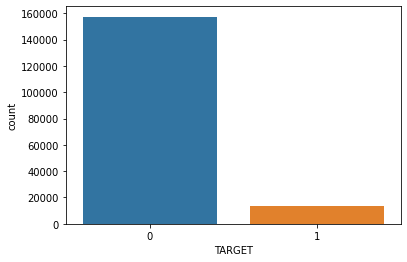

In [1897]:
sns.countplot(x = "TARGET", data = train)
train.loc[:, 'TARGET'].value_counts()

In [1898]:
print(train.info())
print("*******************************")
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171202 entries, 0 to 171201
Data columns (total 93 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SK_ID_CURR                      171202 non-null  int64  
 1   TARGET                          171202 non-null  int64  
 2   NAME_CONTRACT_TYPE              171202 non-null  object 
 3   CODE_GENDER                     171202 non-null  object 
 4   FLAG_OWN_CAR                    136961 non-null  object 
 5   FLAG_OWN_REALTY                 136961 non-null  object 
 6   CNT_CHILDREN                    171202 non-null  int64  
 7   AMT_INCOME_TOTAL                171202 non-null  float64
 8   AMT_CREDIT                      171202 non-null  float64
 9   AMT_ANNUITY                     171196 non-null  float64
 10  AMT_GOODS_PRICE                 171039 non-null  float64
 11  NAME_TYPE_SUITE                 170455 non-null  object 
 12  NAME_INCOME_TYPE

In [1899]:
pd.set_option('display.max_rows', train.shape[0])
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,171202.0,85600.500000,49421.904730,0.000000e+00,42800.250000,85600.500000,128400.750000,1.712010e+05
TARGET,171202.0,0.080729,0.272420,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,171202.0,0.416490,0.720138,0.000000e+00,0.000000,0.000000,1.000000,1.400000e+01
AMT_INCOME_TOTAL,171202.0,168371.213673,107234.793540,2.610000e+04,112500.000000,146250.000000,202500.000000,1.350000e+07
AMT_CREDIT,171202.0,599129.309526,402816.996913,4.500000e+04,270000.000000,514602.000000,808650.000000,4.050000e+06
AMT_ANNUITY,171196.0,27127.500701,14538.361801,1.980000e+03,16546.500000,24916.500000,34600.500000,2.580255e+05
AMT_GOODS_PRICE,171039.0,538466.926517,369692.126605,4.500000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,171202.0,0.020839,0.013803,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,171202.0,-16045.340504,4363.792228,-2.522900e+04,-19686.000000,-15778.000000,-12420.000000,-7.673000e+03
DAYS_EMPLOYED,171202.0,63960.411969,141401.513149,-1.791200e+04,-2772.000000,-1215.000000,-288.000000,3.652430e+05


In [1900]:
pd.DataFrame(train.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",171202
EXT_SOURCE_1,118928
OWN_CAR_AGE,112992
EXT_SOURCE_3,54586
OCCUPATION_TYPE,53745
FLAG_OWN_CAR,34241
FLAG_OWN_REALTY,34241
YEARS_EMPLOYED,30898
AMT_REQ_CREDIT_BUREAU_YEAR,23116
AMT_REQ_CREDIT_BUREAU_QRT,23116


In [1901]:
pd.DataFrame(test.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",61500
EXT_SOURCE_1,42912
OWN_CAR_AGE,40909
EXT_SOURCE_3,19690
OCCUPATION_TYPE,18734
FLAG_OWN_CAR,12334
FLAG_OWN_REALTY,12334
AMT_REQ_CREDIT_BUREAU_YEAR,8513
AMT_REQ_CREDIT_BUREAU_QRT,8513
AMT_REQ_CREDIT_BUREAU_HOUR,8513


# Preprocessing

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
1. Numerical Field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [1902]:
threshold_train = len(train) * 0.60
int(threshold_train)

102721

In [1903]:
threshold_test = len(test) * 0.60
int(threshold_test)

36900

In [1904]:
print("In train data:\n")
print(train.columns[train.isnull().sum() > int(threshold_train)])
print("******************************************")
print("In test data:\n")
print(test.columns[test.isnull().sum() > int(threshold_test)])

In train data:

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', (False, 'OWN_CAR_AGE')], dtype='object')
******************************************
In test data:

Index(['OWN_CAR_AGE', 'EXT_SOURCE_1', (False, 'OWN_CAR_AGE')], dtype='object')


In [1905]:
train_new = train#.dropna(axis=1, thresh=threshold_train)
print(train_new.shape)
print("******************************************")
test_new = test#.dropna(axis=1, thresh=threshold_test)
print(test_new.shape)

(171202, 93)
******************************************
(61500, 92)


In [1906]:
numeric_feature = train_new.dtypes!=object
final_numeric_feature = train_new.columns[numeric_feature].tolist()

#----------------------------------------------------
numeric_feature_test = test_new.dtypes!=object
final_numeric_feature_test = test_new.columns[numeric_feature_test].tolist()

In [1907]:
numeric = train_new[final_numeric_feature]

#-------------------------------------------
numeric_test = test_new[final_numeric_feature_test]
numeric.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,NUM_NAME_TYPE_SUITE,NUM_YEARS_BIRTH,NUM_YEARS_LAST_PHONE_CHANGE,ROUND_RT_CREDIT_0.0,ROUND_RT_CREDIT_1.0,ROUND_RT_CREDIT_2.0,ROUND_RT_CREDIT_3.0,ROUND_RT_CREDIT_4.0,ROUND_RT_CREDIT_5.0,ROUND_RT_CREDIT_6.0
0,0,0,0,112500.0,755190.0,36328.5,675000.0,0.010032,-9233,-878,...,0.081859,0.106890,0.097060,0,0,0,0,0,0,1
1,1,0,0,225000.0,585000.0,16893.0,585000.0,0.008019,-20148,365243,...,0.081859,0.058252,0.091687,0,0,0,1,0,0,0
2,2,0,0,54000.0,334152.0,18256.5,270000.0,0.004960,-18496,-523,...,0.074208,0.069032,0.097060,0,0,0,0,0,0,1
3,3,0,0,67500.0,152820.0,8901.0,135000.0,0.005002,-24177,365243,...,0.072113,0.031373,0.092564,0,0,1,0,0,0,0
4,4,1,0,157500.0,271066.5,21546.0,234000.0,0.006296,-10685,-697,...,0.081859,0.107514,0.076172,0,0,1,0,0,0,0


In [1908]:
discrete_features = numeric.dtypes==int
final_discrete_feature = numeric.columns[discrete_features].tolist()
discrete = numeric[final_discrete_feature]

#-------------------------------------------
discrete_features_test = numeric_test.dtypes==int
final_discrete_feature_test = numeric_test.columns[discrete_features_test].tolist()
discrete_test = numeric_test[final_discrete_feature_test]

discrete.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,...,AMT_REQ_CREDIT_BUREAU_YEAR_NAN,OWN_CAR_AGE_NAN,EXT_SOURCE_1_NAN,FLAG_RT_CREDIT_OVER1,FLAG_NOT_EMPLOYED,FLAG_UNDER30,FLAG_D30,FLAG_D60,FLAG_O30,FLAG_O60
0,0,0,0,-9233,-878,-522,1,1,1,1,...,1,1,1,1,0,1,1,1,0,1
1,1,0,0,-20148,365243,-3436,1,0,0,1,...,0,1,1,1,1,1,1,1,0,1
2,2,0,0,-18496,-523,-2050,1,1,1,1,...,1,1,1,1,0,1,1,1,1,1
3,3,0,0,-24177,365243,-3951,1,0,0,1,...,0,1,1,1,1,1,1,1,0,1
4,4,1,0,-10685,-697,-3226,1,1,1,1,...,0,1,0,1,0,1,1,1,0,1


In [1909]:
pd.DataFrame(discrete.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
AMT_REQ_CREDIT_BUREAU_YEAR_NAN,0
"(False, OWN_CAR_AGE_64)",0
OWN_CAR_AGE_65,0
"(False, OWN_CAR_AGE_65)",0
FLAG_OWN_REALTY_NAN,0
AMT_REQ_CREDIT_BUREAU_HOUR_NAN,0
AMT_REQ_CREDIT_BUREAU_MON_NAN,0
AMT_REQ_CREDIT_BUREAU_QRT_NAN,0
OWN_CAR_AGE_NAN,0


In [1910]:
pd.DataFrame(discrete_test.isnull().sum().sort_values(ascending = False))

,0
SK_ID_CURR,0
OWN_CAR_AGE_64,0
OWN_CAR_AGE_65,0
"(False, OWN_CAR_AGE_65)",0
FLAG_OWN_REALTY_NAN,0
AMT_REQ_CREDIT_BUREAU_HOUR_NAN,0
AMT_REQ_CREDIT_BUREAU_MON_NAN,0
AMT_REQ_CREDIT_BUREAU_QRT_NAN,0
AMT_REQ_CREDIT_BUREAU_YEAR_NAN,0
OWN_CAR_AGE_NAN,0


In [1911]:
continuous_features = numeric.dtypes==float
final_continuous_feature = numeric.columns[continuous_features].tolist()
continuous = numeric[final_continuous_feature]

#-------------------------------------------
continuous_features_test = numeric_test.dtypes==float
final_continuous_feature_test = numeric_test.columns[continuous_features_test].tolist()
continuous_test = numeric_test[final_continuous_feature_test]

continuous.head()

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,...,YEARS_LAST_PHONE_CHANGE,MONTH_LAST_PHONE_CHANGE,NUM_ORGANIZATION_TYPE,NUM_NAME_FAMILY_STATUS,NUM_NAME_INCOME_TYPE,NUM_NAME_EDUCATION_TYPE,NUM_NAME_HOUSING_TYPE,NUM_NAME_TYPE_SUITE,NUM_YEARS_BIRTH,NUM_YEARS_LAST_PHONE_CHANGE
0,112500.0,755190.0,36328.5,675000.0,0.010032,-333.0,NaN,2.0,NaN,0.372591,...,-1.0,-10.0,0.059707,0.075565,0.095482,0.053692,0.077839,0.081859,0.106890,0.097060
1,225000.0,585000.0,16893.0,585000.0,0.008019,-4469.0,NaN,2.0,NaN,0.449567,...,-2.0,-21.0,0.054243,0.075565,0.054184,0.089218,0.077839,0.081859,0.058252,0.091687
2,54000.0,334152.0,18256.5,270000.0,0.004960,-3640.0,NaN,2.0,NaN,0.569503,...,-1.0,-18.0,0.082700,0.075565,0.058882,0.089218,0.077839,0.074208,0.069032,0.097060
3,67500.0,152820.0,8901.0,135000.0,0.005002,-4950.0,NaN,1.0,NaN,0.105235,...,0.0,0.0,0.054243,0.057529,0.054184,0.110642,0.077839,0.072113,0.031373,0.092564
4,157500.0,271066.5,21546.0,234000.0,0.006296,-5101.0,NaN,2.0,0.342344,0.202490,...,-3.0,-41.0,0.093614,0.075565,0.075212,0.089218,0.117996,0.081859,0.107514,0.076172


In [1912]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",171202
EXT_SOURCE_1,118928
OWN_CAR_AGE,112992
EXT_SOURCE_3,54586
YEARS_EMPLOYED,30898
AMT_REQ_CREDIT_BUREAU_QRT,23116
AMT_REQ_CREDIT_BUREAU_MON,23116
AMT_REQ_CREDIT_BUREAU_HOUR,23116
AMT_REQ_CREDIT_BUREAU_YEAR,23116
NUM_NAME_TYPE_SUITE,747


In [1913]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",61500
EXT_SOURCE_1,42912
OWN_CAR_AGE,40909
EXT_SOURCE_3,19690
AMT_REQ_CREDIT_BUREAU_YEAR,8513
AMT_REQ_CREDIT_BUREAU_QRT,8513
AMT_REQ_CREDIT_BUREAU_MON,8513
AMT_REQ_CREDIT_BUREAU_HOUR,8513
NUM_NAME_TYPE_SUITE,248
DEF_30_CNT_SOCIAL_CIRCLE,181


In [1914]:
continuous_col = continuous.columns

In [1915]:
Q1 = train_new.quantile(0.25)
Q3 = train_new.quantile(0.75)
IQR = Q3 - Q1

In [1916]:
#for i in range(len(continuous_col)):
#    preprocess(continuous[continuous_col], continuous_col[i])

In [1917]:
continuous_is_null = continuous.isnull().sum() != 0
final_continuous_feature = continuous.columns[continuous_is_null].tolist()
print("In train: \n",final_continuous_feature)

print("****************************************")
continuous_is_null_test = continuous_test.isnull().sum() != 0
final_continuous_feature_test = continuous_test.columns[continuous_is_null_test].tolist()
print("In test: \n",final_continuous_feature_test)

In train: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', (False, 'OWN_CAR_AGE'), 'RT_GOODS_PRICE', 'RT_ANNUITY', 'YEARS_EMPLOYED', 'YEARS_LAST_PHONE_CHANGE', 'MONTH_LAST_PHONE_CHANGE', 'NUM_NAME_TYPE_SUITE', 'NUM_YEARS_LAST_PHONE_CHANGE']
****************************************
In test: 
 ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', (False, 'OWN_CAR_AGE'), 'RT_GOODS_PRICE', 'RT_ANNUITY', 'NUM_NAME_TYPE_SUITE']


In [1918]:
print("In train:\n")
for i in range(len(final_continuous_feature)):
    replace_mean(continuous, final_continuous_feature[i])

print("************************************")
print("In test:\n")
for i in range(len(final_continuous_feature_test)):
    replace_mean(continuous_test, final_continuous_feature_test[i])

In train:

NaN in AMT_ANNUITY raplaced with 27127.500700950957
NaN in AMT_GOODS_PRICE raplaced with 538466.9265167593
NaN in OWN_CAR_AGE raplaced with 12.024428792303727
NaN in CNT_FAM_MEMBERS raplaced with 2.1523306074766353
NaN in EXT_SOURCE_1 raplaced with 0.5016917304189625
NaN in EXT_SOURCE_2 raplaced with 0.5145082557908564
NaN in EXT_SOURCE_3 raplaced with 0.5111771488927158
NaN in DEF_30_CNT_SOCIAL_CIRCLE raplaced with 0.14391533151275773
NaN in OBS_60_CNT_SOCIAL_CIRCLE raplaced with 1.4064063946742302
NaN in DEF_60_CNT_SOCIAL_CIRCLE raplaced with 0.10043834460449358
NaN in DAYS_LAST_PHONE_CHANGE raplaced with -962.411218392416
NaN in AMT_REQ_CREDIT_BUREAU_HOUR raplaced with 0.006651540321164728
NaN in AMT_REQ_CREDIT_BUREAU_MON raplaced with 0.26841835149845356
NaN in AMT_REQ_CREDIT_BUREAU_QRT raplaced with 0.26754723606552944
NaN in AMT_REQ_CREDIT_BUREAU_YEAR raplaced with 1.9036438285860915
NaN in (False, 'OWN_CAR_AGE') raplaced with nan
NaN in RT_GOODS_PRICE raplaced with 0.

In [1919]:
pd.DataFrame(continuous.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",171202
AMT_INCOME_TOTAL,0
RT_GOODS_PRICE,0
RT_ANNUITY,0
YEARS_ID_PUBLISH,0
YEARS_REGISTRATION,0
YEARS_EMPLOYED,0
YEARS_BIRTH,0
YEARS_LAST_PHONE_CHANGE,0
MONTH_LAST_PHONE_CHANGE,0


In [1920]:
pd.DataFrame(continuous_test.isnull().sum().sort_values(ascending = False))

,0
"(False, OWN_CAR_AGE)",61500
AMT_INCOME_TOTAL,0
RT_GOODS_PRICE,0
RT_ANNUITY,0
YEARS_ID_PUBLISH,0
YEARS_REGISTRATION,0
YEARS_EMPLOYED,0
YEARS_BIRTH,0
YEARS_LAST_PHONE_CHANGE,0
MONTH_LAST_PHONE_CHANGE,0


In [1921]:
numeric[continuous_col] = continuous[continuous_col]

# ----------------------------------------------
numeric_test[continuous_col] = continuous_test[continuous_col]

In [1922]:
continuous_test.columns

Index([           'AMT_INCOME_TOTAL',                  'AMT_CREDIT',
                       'AMT_ANNUITY',             'AMT_GOODS_PRICE',
        'REGION_POPULATION_RELATIVE',           'DAYS_REGISTRATION',
                       'OWN_CAR_AGE',             'CNT_FAM_MEMBERS',
                      'EXT_SOURCE_1',                'EXT_SOURCE_2',
                      'EXT_SOURCE_3',    'DEF_30_CNT_SOCIAL_CIRCLE',
          'OBS_60_CNT_SOCIAL_CIRCLE',    'DEF_60_CNT_SOCIAL_CIRCLE',
            'DAYS_LAST_PHONE_CHANGE',  'AMT_REQ_CREDIT_BUREAU_HOUR',
         'AMT_REQ_CREDIT_BUREAU_MON',   'AMT_REQ_CREDIT_BUREAU_QRT',
        'AMT_REQ_CREDIT_BUREAU_YEAR',        (False, 'OWN_CAR_AGE'),
                         'RT_CREDIT',              'RT_GOODS_PRICE',
                        'RT_ANNUITY',            'YEARS_ID_PUBLISH',
                'YEARS_REGISTRATION',              'YEARS_EMPLOYED',
                       'YEARS_BIRTH',     'YEARS_LAST_PHONE_CHANGE',
           'MONTH_LAST_PHONE_CHANG

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Outlier</h3></center>
</div>

In [1923]:
col_names = numeric.columns

# ------------------------------------
col_names_test = numeric_test.columns

In [1924]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(outlier_detect(numeric,col_names[i]).shape[0])))
    
print("\n\n***************************************\n")
print("In test:\n")
for i in range(len(col_names_test)):
    print("{}: {}".format(col_names_test[i],(outlier_detect(numeric_test,col_names_test[i]).shape[0])))

In train:

SK_ID_CURR: 0
TARGET: 13821
CNT_CHILDREN: 2345
AMT_INCOME_TOTAL: 7784
AMT_CREDIT: 3630
AMT_ANNUITY: 4179
AMT_GOODS_PRICE: 8196
REGION_POPULATION_RELATIVE: 4624
DAYS_BIRTH: 0
DAYS_EMPLOYED: 40224
DAYS_REGISTRATION: 348
DAYS_ID_PUBLISH: 0
OWN_CAR_AGE: 2730
FLAG_MOBIL: 1
FLAG_EMP_PHONE: 30903
FLAG_WORK_PHONE: 34193
FLAG_CONT_MOBILE: 289
FLAG_PHONE: 0
FLAG_EMAIL: 9773
CNT_FAM_MEMBERS: 2184
REGION_RATING_CLIENT: 44800
REGION_RATING_CLIENT_W_CITY: 43420
REG_REGION_NOT_LIVE_REGION: 2603
REG_REGION_NOT_WORK_REGION: 8664
LIVE_REGION_NOT_WORK_REGION: 6979
REG_CITY_NOT_LIVE_CITY: 13422
REG_CITY_NOT_WORK_CITY: 39386
LIVE_CITY_NOT_WORK_CITY: 30672
EXT_SOURCE_1: 0
EXT_SOURCE_2: 0
EXT_SOURCE_3: 0
DEF_30_CNT_SOCIAL_CIRCLE: 20186
OBS_60_CNT_SOCIAL_CIRCLE: 10904
DEF_60_CNT_SOCIAL_CIRCLE: 14982
DAYS_LAST_PHONE_CHANGE: 250
AMT_REQ_CREDIT_BUREAU_HOUR: 24049
AMT_REQ_CREDIT_BUREAU_MON: 47469
AMT_REQ_CREDIT_BUREAU_QRT: 51389
AMT_REQ_CREDIT_BUREAU_YEAR: 1858
OWN_CAR_AGE_64: 0
(False, 'OWN_CAR_AGE_64

In [1925]:
outlier = []
for i in range(len(final_numeric_feature)):
    if outlier_detect(numeric[final_numeric_feature],final_numeric_feature[i]).shape[0] !=0:
        outlier.append(final_numeric_feature[i])

outlier_test = []
for i in range(len(final_numeric_feature_test)):
    if outlier_detect(numeric_test[final_numeric_feature_test],final_numeric_feature_test[i]).shape[0] !=0:
        outlier_test.append(final_numeric_feature_test[i])

In [1926]:
# without TARGET field
col_names = outlier_test

In [1927]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 2345
AMT_INCOME_TOTAL: 7784
AMT_CREDIT: 3630
AMT_ANNUITY: 4179
AMT_GOODS_PRICE: 8196
REGION_POPULATION_RELATIVE: 4624
DAYS_EMPLOYED: 30898
DAYS_REGISTRATION: 0
OWN_CAR_AGE: 2730
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 34193
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 9773
CNT_FAM_MEMBERS: 2184
REGION_RATING_CLIENT: 26999
REGION_RATING_CLIENT_W_CITY: 24517
REG_REGION_NOT_LIVE_REGION: 2603
REG_REGION_NOT_WORK_REGION: 8664
LIVE_REGION_NOT_WORK_REGION: 6979
REG_CITY_NOT_LIVE_CITY: 13422
REG_CITY_NOT_WORK_CITY: 39386
LIVE_CITY_NOT_WORK_CITY: 30672
DEF_30_CNT_SOCIAL_CIRCLE: 20186
OBS_60_CNT_SOCIAL_CIRCLE: 10904
DEF_60_CNT_SOCIAL_CIRCLE: 14982
DAYS_LAST_PHONE_CHANGE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 24049
AMT_REQ_CREDIT_BUREAU_MON: 47469
AMT_REQ_CREDIT_BUREAU_QRT: 51389
AMT_REQ_CREDIT_BUREAU_YEAR: 1858
FLAG_OWN_REALTY_NAN: 34241
AMT_REQ_CREDIT_BUREAU_HOUR_NAN: 23116
AMT_REQ_CREDIT_BUREAU_MON_NAN: 23116
AMT_REQ_CREDIT_BUREAU_QRT_NAN: 23116
AMT_REQ_CREDIT_BUREAU_YEAR_NAN: 23116
RT_CREDIT: 

In [1928]:
for i in range(len(col_names)):
    replace_upper(numeric, col_names[i])   
    
#------------------------------------------------------
for i in range(len(col_names)):
    replace_upper(numeric_test, col_names[i])   

In [1929]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(upper_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 0
DAYS_REGISTRATION: 0
OWN_CAR_AGE: 0
FLAG_EMP_PHONE: 0
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 0
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 0
REGION_RATING_CLIENT_W_CITY: 0
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 0
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0
FLAG_OWN_REALTY_NAN: 0
AMT_REQ_CREDIT_BUREAU_HOUR_NAN: 0
AMT_REQ_CREDIT_BUREAU_MON_NAN: 0
AMT_REQ_CREDIT_BUREAU_QRT_NAN: 0
AMT_REQ_CREDIT_BUREAU_YEAR_NAN: 0
RT_CREDIT: 0
FLAG_RT_CREDIT_OVER1: 0
RT_GOODS_PRICE: 0
RT_ANNUITY: 0
YEARS_REGISTRATION: 0
YEARS_EMPLOYED: 0
FLAG_NOT_EMPL

In [1930]:
print("In train:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names)):
    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

In train:

CNT_CHILDREN: 0
AMT_INCOME_TOTAL: 0
AMT_CREDIT: 0
AMT_ANNUITY: 0
AMT_GOODS_PRICE: 0
REGION_POPULATION_RELATIVE: 0
DAYS_EMPLOYED: 9326
DAYS_REGISTRATION: 348
OWN_CAR_AGE: 0
FLAG_EMP_PHONE: 30903
FLAG_WORK_PHONE: 0
FLAG_CONT_MOBILE: 289
FLAG_EMAIL: 0
CNT_FAM_MEMBERS: 0
REGION_RATING_CLIENT: 17801
REGION_RATING_CLIENT_W_CITY: 18903
REG_REGION_NOT_LIVE_REGION: 0
REG_REGION_NOT_WORK_REGION: 0
LIVE_REGION_NOT_WORK_REGION: 0
REG_CITY_NOT_LIVE_CITY: 0
REG_CITY_NOT_WORK_CITY: 0
LIVE_CITY_NOT_WORK_CITY: 0
DEF_30_CNT_SOCIAL_CIRCLE: 0
OBS_60_CNT_SOCIAL_CIRCLE: 0
DEF_60_CNT_SOCIAL_CIRCLE: 0
DAYS_LAST_PHONE_CHANGE: 250
AMT_REQ_CREDIT_BUREAU_HOUR: 0
AMT_REQ_CREDIT_BUREAU_MON: 0
AMT_REQ_CREDIT_BUREAU_QRT: 0
AMT_REQ_CREDIT_BUREAU_YEAR: 0
FLAG_OWN_REALTY_NAN: 0
AMT_REQ_CREDIT_BUREAU_HOUR_NAN: 0
AMT_REQ_CREDIT_BUREAU_MON_NAN: 0
AMT_REQ_CREDIT_BUREAU_QRT_NAN: 0
AMT_REQ_CREDIT_BUREAU_YEAR_NAN: 0
RT_CREDIT: 0
FLAG_RT_CREDIT_OVER1: 9036
RT_GOODS_PRICE: 14
RT_ANNUITY: 0
YEARS_REGISTRATION: 298
YEAR

In [1931]:
for i in range(len(col_names)):
    replace_lower(numeric, col_names[i])
    
# #--------------------------------------------------
for i in range(len(col_names)):
    replace_lower(numeric_test, col_names[i])

In [1932]:
#print("In train:\n")
#for i in range(len(col_names)):
#    print("{}: {}".format(col_names[i],(lower_outlier(numeric,col_names[i]).shape[0])))
    
#print("\n\n****************************************\n")
#print("In test:\n")
#for i in range(len(col_names)):
#    print("{}: {}".format(col_names[i],(lower_outlier(numeric_test,col_names[i]).shape[0])))

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
2. Categorical field</h3>
</div>

In [1933]:
train_new = pd.get_dummies(train_new, columns=['NAME_EDUCATION_TYPE'])
test_new = pd.get_dummies(test_new, columns=['NAME_EDUCATION_TYPE'])


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [1934]:
categorical_feature = train_new.dtypes==object
final_categorical_feature = train_new.columns[categorical_feature].tolist()

#----------------------------------------------------
categorical_feature_test = test_new.dtypes==object
final_categorical_feature_test = test_new.columns[categorical_feature_test].tolist()

In [1935]:
categorical = train_new[final_categorical_feature]

#---------------------------------------------
categorical_test = test_new[final_categorical_feature_test]
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,Cash loans,F,N,N,Unaccompanied,Working,Married,House / apartment,Core staff,School
1,Cash loans,F,N,Y,Unaccompanied,Pensioner,Married,House / apartment,NaN,XNA
2,Cash loans,F,N,Y,Family,State servant,Married,House / apartment,Core staff,Postal
3,Cash loans,F,N,Y,Children,Pensioner,Widow,House / apartment,NaN,XNA
4,Cash loans,M,N,N,Unaccompanied,Commercial associate,Married,With parents,Drivers,Business Entity Type 3


In [1936]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,53745
FLAG_OWN_CAR,34241
FLAG_OWN_REALTY,34241
NAME_TYPE_SUITE,747
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
ORGANIZATION_TYPE,0


In [1937]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
OCCUPATION_TYPE,18734
FLAG_OWN_CAR,12334
FLAG_OWN_REALTY,12334
NAME_TYPE_SUITE,248
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
NAME_INCOME_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
ORGANIZATION_TYPE,0


In [1938]:
col_names_cat = categorical.columns

******************** NAME_CONTRACT_TYPE ********************



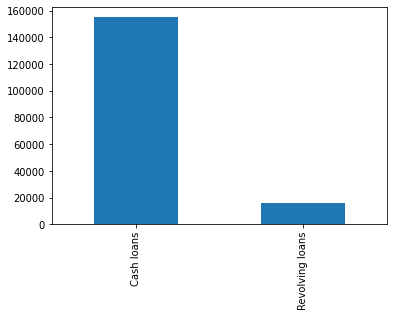

******************** CODE_GENDER ********************



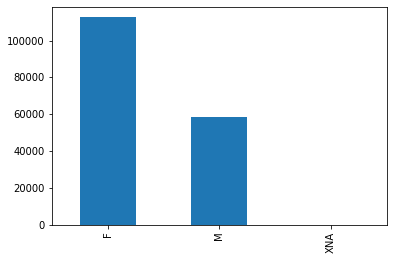

******************** FLAG_OWN_CAR ********************



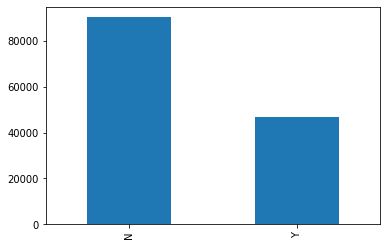

******************** FLAG_OWN_REALTY ********************



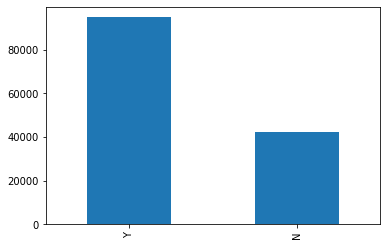

******************** NAME_TYPE_SUITE ********************



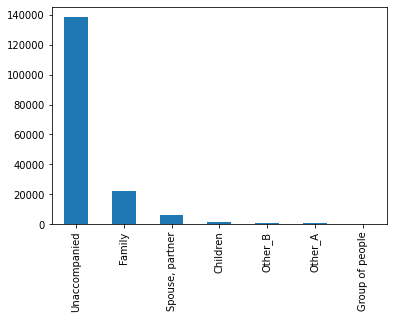

******************** NAME_INCOME_TYPE ********************



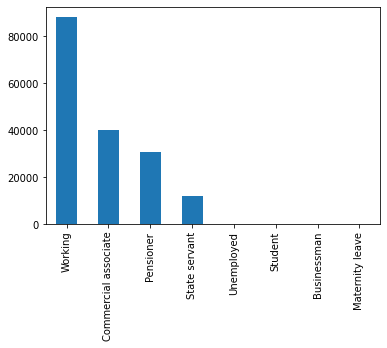

******************** NAME_FAMILY_STATUS ********************



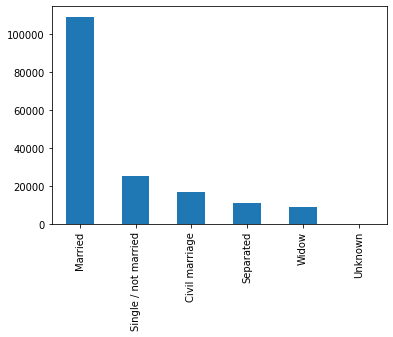

******************** NAME_HOUSING_TYPE ********************



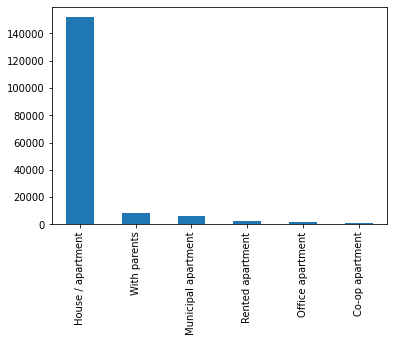

******************** OCCUPATION_TYPE ********************



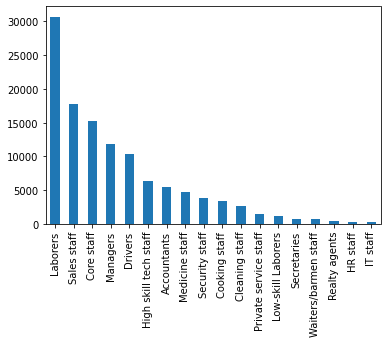

******************** ORGANIZATION_TYPE ********************



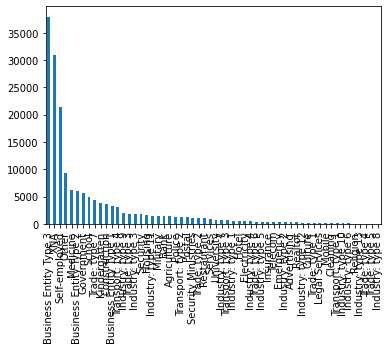

In [1939]:
for i in range(len(col_names_cat)):
    preprocess_cat(categorical, col_names_cat[i])

In [1940]:
print("unique number is = {}\nunique values are: \n{} ".format(len(train_new['ORGANIZATION_TYPE'].unique()), train_new['ORGANIZATION_TYPE'].unique()))

unique number is = 58
unique values are: 
['School' 'XNA' 'Postal' 'Business Entity Type 3' 'Transport: type 4'
 'Trade: type 3' 'Military' 'Self-employed' 'Bank'
 'Business Entity Type 2' 'Kindergarten' 'Trade: type 7' 'Hotel'
 'Services' 'Other' 'Medicine' 'Government' 'Construction' 'Agriculture'
 'University' 'Religion' 'Industry: type 4' 'Advertising' 'Legal Services'
 'Business Entity Type 1' 'Industry: type 9' 'Industry: type 11'
 'Industry: type 3' 'Trade: type 6' 'Industry: type 10' 'Trade: type 1'
 'Housing' 'Industry: type 1' 'Security Ministries' 'Industry: type 12'
 'Security' 'Industry: type 7' 'Transport: type 3' 'Transport: type 2'
 'Police' 'Realtor' 'Restaurant' 'Culture' 'Insurance' 'Emergency'
 'Mobile' 'Electricity' 'Telecom' 'Trade: type 2' 'Industry: type 13'
 'Industry: type 2' 'Transport: type 1' 'Industry: type 5'
 'Industry: type 6' 'Cleaning' 'Trade: type 4' 'Industry: type 8'
 'Trade: type 5'] 


In [1941]:
print("In train:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical, col_names_cat[i])

print("\n\n****************************************\n")
print("In test:\n")
for i in range(len(col_names_cat)):
    replace_mode(categorical_test, col_names_cat[i])

In train:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in ORGANIZATION_TYPE raplaced with Business Entity Type 3


****************************************

In test:

NaN in NAME_CONTRACT_TYPE raplaced with Cash loans
NaN in CODE_GENDER raplaced with F
NaN in FLAG_OWN_CAR raplaced with N
NaN in FLAG_OWN_REALTY raplaced with Y
NaN in NAME_TYPE_SUITE raplaced with Unaccompanied
NaN in NAME_INCOME_TYPE raplaced with Working
NaN in NAME_FAMILY_STATUS raplaced with Married
NaN in NAME_HOUSING_TYPE raplaced with House / apartment
NaN in OCCUPATION_TYPE raplaced with Laborers
NaN in ORGANIZATION_TYPE raplaced with Business Entity 

In [1942]:
pd.DataFrame(categorical.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0
ORGANIZATION_TYPE,0


In [1943]:
pd.DataFrame(categorical_test.isnull().sum().sort_values(ascending = False))

,0
NAME_CONTRACT_TYPE,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
NAME_TYPE_SUITE,0
NAME_INCOME_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0
ORGANIZATION_TYPE,0


In [1944]:
categorical.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
# ---------------------------------------------
categorical_test.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

In [1945]:
le = LabelEncoder() 
categorical = categorical.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical_test = categorical_test.apply(lambda col_names_cat: le.fit_transform(col_names_cat)) 
categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE
0,0,0,0,0,6,7,1,1,3
1,0,0,0,1,6,3,1,1,8
2,0,0,0,1,1,4,1,1,3
3,0,0,0,1,0,3,5,1,8
4,0,1,0,0,6,1,1,5,4


In [1946]:
print("In train: ",categorical.shape)
print("In test: ",categorical_test.shape)

In train:  (171202, 9)
In test:  (61500, 9)


In [1947]:
col_names_cat = categorical.columns

In [1948]:
train_new[col_names_cat] = categorical[col_names_cat]
train_new[col_names] = numeric[col_names]

# ----------------------------------------------------
test_new[col_names] = numeric_test[col_names]
test_new[col_names_cat] = categorical_test[col_names_cat]

In [1949]:
#train_new = pd.get_dummies(train_new, columns=['ORGANIZATION_TYPE'])
#test_new = pd.get_dummies(test_new, columns =['ORGANIZATION_TYPE'])

In [1950]:
train_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)
test_new.drop(['ORGANIZATION_TYPE'], axis=1, inplace=True)

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#410159; font-weight: bold; font-family: Cursive">
Manage Duplicate Data</h3></center>
</div>

In [1951]:
print("In train: ",train_new.loc[train.duplicated()].shape)
#--------------------------------------------------
print("In test: ",test_new.loc[test.duplicated()].shape)

In train:  (0, 96)
In test:  (0, 95)


# Normalization

In [1952]:
x_train = train_new.drop("TARGET", axis = 1)
y = train_new['TARGET']

In [1953]:
test_new.columns

Index([                                       'SK_ID_CURR',
                                      'NAME_CONTRACT_TYPE',
                                             'CODE_GENDER',
                                            'FLAG_OWN_CAR',
                                         'FLAG_OWN_REALTY',
                                            'CNT_CHILDREN',
                                        'AMT_INCOME_TOTAL',
                                              'AMT_CREDIT',
                                             'AMT_ANNUITY',
                                         'AMT_GOODS_PRICE',
                                         'NAME_TYPE_SUITE',
                                        'NAME_INCOME_TYPE',
                                      'NAME_FAMILY_STATUS',
                                       'NAME_HOUSING_TYPE',
                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH',
                                        

In [1954]:
x_train.columns

Index([                                       'SK_ID_CURR',
                                      'NAME_CONTRACT_TYPE',
                                             'CODE_GENDER',
                                            'FLAG_OWN_CAR',
                                         'FLAG_OWN_REALTY',
                                            'CNT_CHILDREN',
                                        'AMT_INCOME_TOTAL',
                                              'AMT_CREDIT',
                                             'AMT_ANNUITY',
                                         'AMT_GOODS_PRICE',
                                         'NAME_TYPE_SUITE',
                                        'NAME_INCOME_TYPE',
                                      'NAME_FAMILY_STATUS',
                                       'NAME_HOUSING_TYPE',
                              'REGION_POPULATION_RELATIVE',
                                              'DAYS_BIRTH',
                                        

In [1955]:
scaler=MinMaxScaler()
col = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 
       'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 
       'NAME_INCOME_TYPE',
       'NAME_FAMILY_STATUS',
       'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2','EXT_SOURCE_3',
       'FLAG_O30', 'FLAG_D30',
       'FLAG_D60',
       'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 
       'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'RT_CREDIT','RT_GOODS_PRICE','RT_ANNUITY', 'YEARS_BIRTH', 'YEARS_EMPLOYED',
       'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH','YEARS_LAST_PHONE_CHANGE','MONTH_LAST_PHONE_CHANGE',
       'FLAG_NOT_EMPLOYED','NUM_ORGANIZATION_TYPE',
       'NUM_NAME_FAMILY_STATUS',
       'NUM_NAME_INCOME_TYPE',
       'NUM_NAME_EDUCATION_TYPE',
       'NUM_NAME_HOUSING_TYPE',
       'NUM_NAME_TYPE_SUITE',
       'FLAG_OWN_REALTY_NAN',
       'DEF_30_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 
       'FLAG_O60',
       'AMT_REQ_CREDIT_BUREAU_HOUR_NAN',
       'AMT_REQ_CREDIT_BUREAU_MON_NAN',
       'AMT_REQ_CREDIT_BUREAU_QRT_NAN',
       'AMT_REQ_CREDIT_BUREAU_YEAR_NAN',
       'AMT_CREDIT',
       'FLAG_UNDER30',
       'FLAG_RT_CREDIT_OVER1',
       'OWN_CAR_AGE', 'EXT_SOURCE_1',
       'OWN_CAR_AGE_NAN',
       'EXT_SOURCE_1_NAN',
       'NUM_YEARS_BIRTH',
       'NUM_YEARS_LAST_PHONE_CHANGE',
       ]

x_train[col] = pd.DataFrame(scaler.fit_transform(x_train[col]))
test_new[col] = pd.DataFrame(scaler.transform(test_new[col]))

# Modeling with tuned hyperparameters

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
We used Random search for tuning hyperparameters</div>

In [1956]:
# Value of hyperparameters for random search

param_lgb = {'learning_rate':[0.2,0.1,0.01,0.05,0.001],
             'num_leaves':range(10,100,10),
              'min_child_samples':range(500,1000,100),
              'reg_alpha':[0.1,0.01,0.2,0.3],
              'reg_lambda':[0.1,0.01,0.2,0.3],
             'n_estimators':range(50,300,50),
              'max_bin': range(500,1500,100)}

#RndSrch_Tune(LGBMClassifier(random_state = 100, n_jobs=-1, class_weight = 'balanced'), 
#              x_train, y, param_lgb)

best score is : 0.7439544639382981
best estimator is : LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_bin=500,
               min_child_samples=600, n_estimators=250, num_leaves=10,
               random_state=100, reg_alpha=0.1, reg_lambda=0.1)
best Params is : {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 10, 'n_estimators': 250, 'min_child_samples': 600, 'max_bin': 500, 'learning_rate': 0.05}
0.7439544639382981

FLAG_D30　更新できました。
FLAG_D60　を加えても全く同じ。
FLAG_O30　更新。
FLAG_O60で成績落ちる。
EXT_SOURCE_2　を落としたら成績が落ちました。
AMTの２項目追加で0.7515669
DAYSの変換で0.751722

DAYS_Phoneで0.75157

AMT/100000で0.751566　落ちた！

FLAG_NOT_EMPLOYED 0.752110

FLAG_FAM_MEM_EQ_2  で0.752102　落ちた！

'NUM_ORGANIZATION_TYPE' 0.752536

NUM_NAMEの大量登録で　0.752446 落ちた！

Num_name_type_suiteを外してみると　0.752446　落ちたまま

さらに

'NUM_NAME_HOUSING_TYPE'を外してみると　0.752446　落ちたまま

さらに

'NUM_OCCUPATION_TYPE'を外してみると　0.752690

'NUM_NAME_HOUSING_TYPE'を戻してみると　0.752690

'NUM_NAME_TYPE_SUITE'を戻してみると　0.752690

'FLAG_OWN_REALTY_NAN'を加えてみても　0.752690

'DEF_30_CNT_SOCIAL_CIRCLE'を戻してみたら　0.752690

'DEF_60_CNT_SOCIAL_CIRCLE'を戻してみたら　 0.752690

'OBS_30_CNT_SOCIAL_CIRCLE'を戻してみたら　0.752549　落ちた　外す

'OBS_60_CNT_SOCIAL_CIRCLE'を外してみると 0.752432 落ちた　もどす 0.752690

'FLAG_O60'をnaのみで入れてみると　0.752690 0を加えると 0.752555 もどす　0.752690

'FLAG_D60'から0を外すと 0.752690

'FLAG_D30'から0を外すと  0.752690

'FLAG_O30'から1を外すと 0.752565 もどす　0.752690

'AMT_REQ_CREDIT_BUREAU_HOUR_NAN'加えてみる　0.752690

'AMT_REQ_CREDIT_BUREAU_YEAR_NAN'加えてみる　0.752690

'AMT_REQ_CREDIT_BUREAU_MON_NAN'加えてみる　0.752690

'AMT_REQ_CREDIT_BUREAU_QRT_NAN',加えてみる 0.752690

AMT_CREDITがスケーリングから外れていたので加えてみる  0.752690

'RT_GOODS_PRICE_INCOME'を加えてみる　0.752582 もどす0.752690

'RT_ANNUITY_INCOME'を加えてみる　0.752523 もどす0.752690

'FLAG_OVER60'を加えてみる0.752690もどす0.752690

'FLAG_OVER50'を加えてみる0.752690もどす0.752690

FLAG_UNDER30を加えてみる0.752690

'NUM_CNT_FAM_MEMBERS'を加えてみる0.752640もどす0.752690

'FLAG_RT_CREDIT_OVER1'を加えてみる0.752690

'AMT_INCOME_TOTAL_LOG'を加えてみる0.752603もどす0.752690

'AMT_CREDIT_LOG'を加えてみる0.752620もどす0.752690

'AMT_GOODS_PRICE_LOG'を加えてみる0.752652もどす0.752690

'AMT_ANNUITY_LOG'を加えてみる0.752611もどす0.752690

'OWN_CAR_AGE', 'EXT_SOURCE_1'を削除しないと0.756976

'OWN_CAR_AGE_NAN'を加えてみる0.757047

'EXT_SOURCE_1_NAN'を加えてみる0.757047

'NUM_YEARS_BIRTH'を加えてみる0.757209

'NUM_YEARS_LAST_PHONE_CHANGE'を加えてみる0.757271

'NUM_YEARS_EMPLOYED'をくわえてみる0.756964　落ちた！戻す。0.757271

'NUM_YEARS_REGISTRATION'をくわえてみる0.756926　落ちた！戻す。0.757271

'NUM_YEARS_ID_PUBLISH'をくわえてみる0.756964　落ちた！戻す。0.757271

'NUM_REALTY_INCOME_CREDIT'を加えてみる0.757244惜しい！'FLAG_OWN_REALTY'外してみる？0.757219間違った戻して'FLAG_OWN_REALTY_NON'外してみる0.757244やっぱりだめ。

REALTY_INCOME_CREDITにしてみる。0.756972さらに駄目。元に戻し

ORGANIZATION_TYPEのドロップをやめる。0.757111良くない。元に戻し。0.757271

ORGANIZATION_TYPEをワンホットエンコーディングに。0.757126 やや良くない。戻す。0.757271

OCCUPATION_TYPEをワンホットエンコーディングに。0.756915　やや良くない。戻す。

NAME_INCOME_TYPEをワンホットエンコーディングに。0.757169 やや良くない。戻す。0.757271

NAME_FAMILY_STATUSをワンホットエンコーディングに。0.756948 悪くなった。戻す。0.757271

NAME_EDUCATION_TYPEをワンホットエンコーディングに。0.757281 良くなった。

収入のカテゴリー化　ワンホットエンコーディングでリベンジ　 0.757142 悪くなった。

借入収入倍率のカテゴリー化　0.757281

OWN_CAR_AGEの不自然な64と65をフラグ化　0.757281




In [1957]:
lgb = LGBMClassifier(**{'reg_lambda': 0.1, 
                        'reg_alpha': 0.1, 
                        'num_leaves': 10, 
                        'n_estimators': 250, 
                        'min_child_samples': 600, 
                        'learning_rate': 0.05,
                        'max_bin': 500,
                        'objective': 'binary',
                        'n_jobs': -1,
                        'class_weight':'balanced',
                        'random_state':100})

scores = cross_validation(x_train, y, lgb)
print(scores)

Score: 0.757281
None


# Submission

In [1958]:
lgb.fit(x_train, y)
y_pred_LGB = lgb.predict(x_train)
y_pred_LGB_test = lgb.predict(test_new)

In [1959]:
output = pd.DataFrame({'SK_ID_CURR': test_new.SK_ID_CURR, 
                       'TARGET': lgb.predict_proba(test_new)[:,1]})
output.head()

,SK_ID_CURR,TARGET
0,171202,0.277073
1,171203,0.712702
2,171204,0.692914
3,171205,0.535338
4,171206,0.733661


In [1960]:
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")
from google.colab import files
files.download('my_submission.csv')

Your submission was successfully saved!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#fef1ff;padding: 25px 10px">
To be continued... 🚧</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #410159;
            letter-spacing:0.5px;">

<center><h4 style="padding: 5px 0px; color:#442efb; font-weight: bold; font-family: Cursive">
    Thanks for your attention and for reviewing my notebook.🙌 <br><br>Please write your comments for me.📝</h4></center>
<center><h4 style="padding: 5px 0px; color:#442efb; font-weight: bold; font-family: Cursive">
If you liked my work and found it useful, please upvote. Thank you🙏</h4></center>
</div>

In [1961]:
train.loc[train['OWN_CAR_AGE']==64,'OWN_CAR_AGE'].count()

1331

In [1962]:
train.loc[train['OWN_CAR_AGE']==65,'OWN_CAR_AGE'].count()

494

In [1963]:
train.loc[train['OWN_CAR_AGE']==91,'OWN_CAR_AGE'].count()

1